In [317]:
from automation import automation,battle,random_battle,random_battle_env,general_battle_env
import numpy as np
from torch import nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
import random
from matplotlib import pyplot as plt
import nashpy as nash

In [4]:
def solve_r_m(r_m):
    a = np.array([
    [r_m[0,0]-r_m[0,1]-r_m[2,0]+r_m[2,1],r_m[1,0]-r_m[1,1]-r_m[2,0]+r_m[2,1]],
    [r_m[0,0]-r_m[0,2]-r_m[2,0]+r_m[2,2],r_m[1,0]-r_m[1,2]-r_m[2,0]+r_m[2,2]]
    ])
    b = np.array([[-r_m[2,0]+r_m[2,1]],[-r_m[2,0]+r_m[2,2]]])
    x = np.linalg.solve(a, b)
    return np.array([x[0][0],x[1][0],1-x.sum()])
    

In [5]:
def gen_next_status(obs):
    hp_a = obs[3]
    hp_b = obs[0]
    att_a = obs[4]
    att_b = obs[1]
    suc_a = obs[5]
    suc_b = obs[2]
    next_obs = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]
    next_obs[0][0] = np.array([max(hp_b-att_a,0),1.,1.,max(hp_a-att_b,0),1.,1.])
    next_obs[0][1] = np.array([hp_b,1.,1.,min(hp_a+att_b,5),att_a,suc_a/2])
    next_obs[0][2] = np.array([hp_b,1.,1.,max(hp_a-att_b,0),att_a,1.])
    next_obs[0][3] = np.array([hp_b,1.,1.,max(hp_a-att_b,0),att_a+1,1.])

    next_obs[1][0] = np.array([min(hp_b+att_a,5),att_b,suc_b/2,hp_a,1.,1.])
    next_obs[1][1] = np.array([hp_b,att_b,suc_b/2,hp_a,att_a,suc_a/2])
    next_obs[1][2] = np.array([hp_b,att_b,suc_b/2,hp_a,att_a,1.])
    next_obs[1][3] = np.array([hp_b,att_b,suc_b/2,hp_a,att_a+1,1.])

    next_obs[2][0] = np.array([max(hp_b-att_a,0),att_b,1.,hp_a,1.,1.])
    next_obs[2][1] = np.array([hp_b,att_b,1.,hp_a,att_a,suc_a/2])
    next_obs[2][2] = np.array([hp_b,att_b,1.,hp_a,att_a,1.])
    next_obs[2][3] = np.array([hp_b,att_b,1.,hp_a,att_a+1,1.])

    next_obs[3][0] = np.array([max(hp_b-att_a,0),att_b+1,1.,hp_a,1.,1.])
    next_obs[3][1] = np.array([hp_b,att_b+1,1.,hp_a,att_a,suc_a/2])
    next_obs[3][2] = np.array([hp_b,att_b+1,1.,hp_a,att_a,1.])
    next_obs[3][3] = np.array([hp_b,att_b+1,1.,hp_a,att_a+1,1.])
    return next_obs


In [264]:
class MLP(nn.Module):
    def __init__(self, input_dim = 6,output_dim = 1,hidden_dim=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) # 输入层 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim) # 输出层
    def forward(self, x):
        # 各层对应的激活函数
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x)) 
        return self.fc3(x)

In [265]:
def gen_r_m(model,next_obs):
    r_m = np.zeros([3,3])

    r_m[0][0] = model(torch.tensor(next_obs[0][0])).item()
    r_m[0][1] = obs_tm1[5]*model(torch.tensor(next_obs[0][1])).item()+(1-obs_tm1[5])*model(torch.tensor(next_obs[0][2])).item()
    r_m[0][2] = model(torch.tensor(next_obs[0][3])).item()

    r_m[1][0] = obs_tm1[2]*model(torch.tensor(next_obs[1][0])).item()+(1-obs_tm1[2])*model(torch.tensor(next_obs[2][0]))
    r_m[1][1] = obs_tm1[2]*obs_tm1[5]*model(torch.tensor(next_obs[1][1])).item()+obs_tm1[2]*(1-obs_tm1[5])*model(torch.tensor(next_obs[2][1])).item()+(1-obs_tm1[2])*obs_tm1[5]*model(torch.tensor(next_obs[1][2])).item()+(1-obs_tm1[2])*(1-obs_tm1[5])*model(torch.tensor(next_obs[2][2])).item()
    r_m[1][2] = obs_tm1[2]*model(torch.tensor(next_obs[1][3])).item()+(1-obs_tm1[2])*model(torch.tensor(next_obs[2][3]))

    r_m[2][0] = model(torch.tensor(next_obs[3][0])).item()
    r_m[2][1] = obs_tm1[5]*model(torch.tensor(next_obs[2][1])).item()+(1-obs_tm1[5])*model(torch.tensor(next_obs[2][2])).item()
    r_m[2][2] = model(torch.tensor(next_obs[3][3])).item()

    return r_m
    


In [277]:
# 初始化模型、损失函数和优化器
model = MLP()
model.float()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)


In [292]:
all_episode_returns = []
all_results = []
first_action = []
n = 0
win = 0
total_return = 0
discount_t = 1
battle_length = []
battle_result = []
train_loss = []
train_episodes = 100000
for _ in tqdm(range(train_episodes)):
    game_loss = []
    n+=1
    env = general_battle_env()
    obs_tm1 = env.get_status()
    a_tm1 = np.random.choice([0,1,2])
    a_ene_tm1 = np.random.choice([0,1,2])
    # vm1 = torch.tensor([0.])
    while not env.end:
        env.step(int(a_tm1),int(a_ene_tm1))###update
        obs_t = env.get_status()#timestep.observation###initial value
        #obs_ene_t = np.concatenate([obs_t[3:], obs_t[0:3]])
        vm1 = model(torch.tensor(obs_tm1))
        v = model(torch.tensor(obs_t))
        r_t = env.reward
        loss = criterion(r_t + discount_t * v,vm1)
        loss.backward()
        optimizer.step()
        
        obs_tm1 = obs_t
        # vm1 = model(torch.tensor(obs_tm1))
        a_tm1 = np.random.choice([0,1,2])
        a_ene_tm1 = np.random.choice([0,1,2])
        game_loss.append(loss.item())

    train_loss.append(np.mean(game_loss))
    battle_result.append(env.result)
    win+=env.result
    all_results.append(win/n)



  0%|          | 0/100000 [00:00<?, ?it/s]

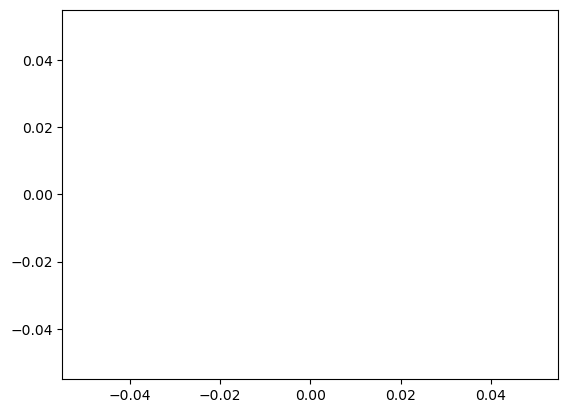

In [312]:
plt.plot(train_loss)
plt.show()

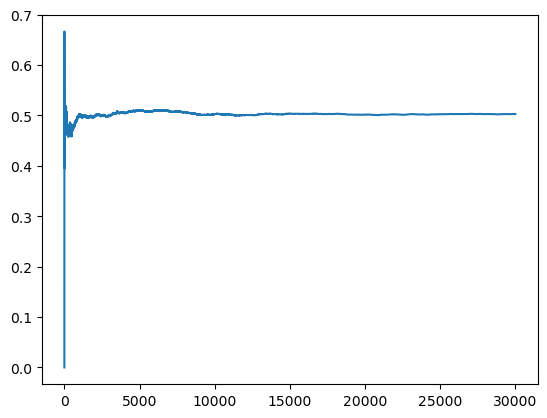

In [280]:
plt.plot(all_results)

In [294]:
model(torch.tensor([0.,1.,1.,4.,1.,1.]))

tensor([-0.6041], grad_fn=<AddBackward0>)

In [295]:
model(torch.tensor([5.,1.,1,5.,1.,1.]))

tensor([0.4483], grad_fn=<AddBackward0>)

In [296]:
env.reward

1

In [297]:
env.get_status()

array([0., 2., 1., 5., 1., 1.], dtype=float32)

In [298]:
r_t + discount_t * v,vm1

(tensor([0.4340], grad_fn=<AddBackward0>),
 tensor([0.3905], grad_fn=<AddBackward0>))

In [290]:
train_loss[-50:]

[0.000794184509572915,
 0.0004700856415027488,
 0.0006946984683963819,
 0.0002985027362650986,
 0.0005584981069356824,
 0.0035064615183803957,
 0.0012648818530252015,
 0.0003999067538235191,
 3.8944125117623685e-05,
 0.00016369307703882895,
 0.0009868783622045561,
 0.0019270231152101285,
 9.065596198828037e-05,
 0.0006075732034484341,
 0.0006532191029171892,
 0.00011913272699833517,
 0.0002411583811105326,
 0.0002685140490257254,
 0.0016108963289298117,
 0.0002175713383820721,
 0.0013575684813531552,
 0.0008519640080325272,
 0.001094398402377313,
 0.003316859811181158,
 0.008349153349627159,
 0.0015586621022626228,
 0.002185136962566503,
 0.0006559736768048714,
 0.0062262404815555785,
 0.00041914878342400437,
 0.0006509322836861359,
 0.00011523480311552703,
 0.003175519022382408,
 0.00013737007605284037,
 0.0004977089991322308,
 0.000382929189800052,
 0.00203393278582098,
 0.0002442221429532765,
 0.000886379617137815,
 0.0013530068035134508,
 0.0006472393566485023,
 0.00245349380029343

In [217]:
obs_t

array([0., 1., 1., 3., 1., 1.], dtype=float32)

In [302]:
model.double()

MLP(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [320]:
all_episode_returns = []
all_results = []
first_action = []
n = 0
win = 0
total_return = 0
discount_t = 1
battle_length = []
battle_result = []
train_loss = []
train_episodes = 1000
for _ in tqdm(range(train_episodes)):
    n+=1
    env = general_battle_env()
    obs_tm1 = env.get_status()
    next_obs = gen_next_status(obs_tm1)
    r_m = gen_r_m(model,next_obs)
    dis_action_a = solve_r_m(r_m)
    dis_action_b = solve_r_m(-1*r_m.T)
    a_tm1 = np.random.choice([0,1,2],p = dis_action_a)
    a_ene_tm1 = np.random.choice([0,1,2],p = dis_action_b)

    while not env.end:
        env.step(int(a_tm1),int(a_ene_tm1))###update
        if env.end:
            break
        obs_t = env.get_status()#timestep.observation###initial value
        #obs_ene_t = np.concatenate([obs_t[3:], obs_t[0:3]])
        vm1 = model(torch.tensor(obs_tm1))
        v = model(torch.tensor(obs_t))
        r_t = env.reward
        loss = criterion(r_t + discount_t * v,vm1)
        loss.backward()
        optimizer.step()

        obs_tm1 = obs_t
        next_obs = gen_next_status(obs_tm1)
        r_m = gen_r_m(model,next_obs)
        dis_action_a = solve_r_m(r_m)
        dis_action_b = solve_r_m(-1*r_m.T)
        a_tm1 = np.random.choice([0,1,2],p = dis_action_a)
        a_ene_tm1 = np.random.choice([0,1,2],p = dis_action_b)
        train_loss.append(loss.item())
    battle_result.append(env.result)
    win+=env.result
    all_results.append(win/n)

  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: probabilities are not non-negative

In [321]:
dis_action_a

array([ 0.15999849,  2.20202992, -1.36202841])

In [323]:
obs_tm1

array([5., 1., 1., 5., 1., 1.], dtype=float32)

In [324]:
r_m

array([[0.4215202 , 0.44023684, 0.4491707 ],
       [0.43967322, 0.43158799, 0.4547669 ],
       [0.4511098 , 0.44023684, 0.47876031]])

In [326]:
model(torch.tensor([5.,1.,1.,5.,1.,1.]))

RuntimeError: expected scalar type Float but found Double

In [315]:
solve_r_m(np.array([
    [0,1,1],
    [-1,0,1],
    [-1,-1,0]
]))

array([ 1., -1.,  1.])

In [41]:
-1*r_m.T

array([[0.32158849, 0.43771618, 0.33369919],
       [0.37424704, 0.40780996, 0.37424704],
       [0.43059545, 0.43201114, 0.26949383]])

In [42]:
r_m

array([[-0.32158849, -0.37424704, -0.43059545],
       [-0.43771618, -0.40780996, -0.43201114],
       [-0.33369919, -0.37424704, -0.26949383]])

In [318]:
solve_r_m(r_m)

array([ 0.15999849,  2.20202992, -1.36202841])

In [1]:
5 &1

1

In [2]:
[2] is not None

True